## Layer Earth crust model

In this model, we build a layered Earth crust model, with two anomalies: slow velocity and fast velocity. The mean velociy is the similar AK135 model.

## AK135 velocity model
| depth(km)  |  vp (km/s)  | vs (km/s)  | rho (kg/m$^3$) |
|----|----|----|----|
|   0.000,   |   5.8000,  |    3.4600,  |    2.7200 |
|  20.000,   |   5.8000,  |    3.4600,  |    2.7200 |
|  20.000,   |   6.5000,  |    3.8500,  |    2.9200 |
|  35.000,   |   6.5000,  |    3.8500,  |    2.9200 |
|  35.000,   |   8.0400,  |    4.4800,  |    3.3198 |
|  77.500,   |   8.0450,  |    4.4900,  |    3.3455 |
| 120.000,   |   8.0500,  |    4.5000,  |    3.3713 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import os
from util import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
out_dir = "models"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [4]:
f0 = 3
vp0 = 7 #km/s
dx, dt = calc_dx_dt(f0, vp0)
dy = dx
n_pml = 15
x_range = [0, 40]
y_range = [0, 20]
t_range = [0, np.sqrt((x_range[1] - x_range[0])**2 + (y_range[1] - y_range[0])**2)/vp0 *2]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
t = np.arange(t_range[0], t_range[1], dt)
nx = len(x)
ny = len(y)
nt = len(t)
rcv_depth = 12
src_depth = ny - 12
mask_extra_depth = 4
print("nx = {}, ny = {}, nt = {}".format(nx, ny, nt))
print("dx = {} km, dy = {} km, dt = {} s".format(dx, dy, dt))

nx = 120, ny = 60, nt = 805
dx = 0.33333333333333337 km, dy = 0.33333333333333337 km, dt = 0.015873015873015876 s


In [5]:
ix_source = np.linspace(30, nx-30, 6).astype('int')
iy_source = np.linspace(30, 40, 2).astype('int')
nx_source = len(ix_source)
ny_source = len(iy_source)
x_source_grid, y_source_grid = np.meshgrid(ix_source, iy_source)
print("source: nx = {}, ny = {}".format(nx_source, ny_source))

source: nx = 6, ny = 2


## source and receiver types:

| index | type |
| :---: | :---: |
|0 | $v_x$ |
|1 | $v_y$ |
|2 | $\sigma_{xx}$ |
|3 | $\sigma_{yy}$ |
|4 | $\sigma_{xy}$ |

In [6]:
src_type = [2]
rcv_type = [0]
src_amp = 1e6

In [7]:
def step_profile(x_range, y_range, step):
    y_step1 = np.round(np.arange(y_range[0], y_range[1]+step, step)/step) * step
    print(y_step1)
    vp_step1 = y_step1/(y_range[1]-y_range[0]) * (8.04-5.8) + 5.8
    vs_step1 = y_step1/(y_range[1]-y_range[0]) * (4.48-3.46) + 3.46
    rho_step1 = y_step1/(y_range[1]-y_range[0]) * (3.32-2.72) + 2.72
    
    y_step2 = y_step1 + (y_step1[1] - y_step1[0] - 1)
    vp_step2 = vp_step1
    vs_step2 = vs_step1
    rho_step2 = rho_step1

    idy = np.argsort(np.hstack([y_step1, y_step2]))
    y_step = np.hstack([y_step1, y_step2])[idy]
    vp_step = np.hstack([vp_step1, vp_step2])[idy]
    vs_step = np.hstack([vs_step1, vs_step2])[idy]
    rho_step = np.hstack([rho_step1, rho_step2])[idy]
    vp_step[-1:] = vp_step[-2]
    vs_step[-1:] = vs_step[-2]
    rho_step[-1:] = rho_step[-2]
    
    return y_step, vp_step, vs_step, rho_step

def build_layer_model(x, y, step):
    y_step, vp_step, vs_step, rho_step = step_profile([x[0], x[-1]], [y[0], y[-1]], step)
    
    vp = interp1d(y_step, vp_step, kind='slinear')(y)
    vs = interp1d(y_step, vs_step, kind='slinear')(y)
    rho = interp1d(y_step, rho_step, kind='slinear')(y)
    
    vp = np.tile(vp[np.newaxis,:], [len(x),1])
    vs = np.tile(vs[np.newaxis,:], [len(x),1])
    rho = np.tile(rho[np.newaxis,:], [len(x),1])
    
    model = {}
    model['vp'] = vp
    model['vs'] = vs
    model['rho'] = rho
    model['x'] = x
    model['y'] = y
    model['dx'] = x[1] - x[0]
    model['dy'] = y[1] - y[0]
    
    return model

step = 4 #km
model = build_layer_model(x, y, step)


[ 0.  4.  8. 12. 16. 20.]


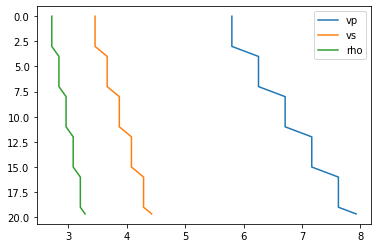

In [8]:
plt.figure()
plt.plot(model['vp'][0,:], y, label='vp')
plt.plot(model['vs'][0,:], y, label='vs')
plt.plot(model['rho'][0,:], y, label='rho')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [9]:
def add_source(ix_source, iy_source, f0, t, width):
    rupture = {}
    rupture['ix'] = []
    rupture['iy'] = []
    src = {}
    src['ix'] = []
    src['iy'] = []
    src['type'] = []
    src['vec'] = []
    src['amp'] = []
    src['shift'] = []
    dt = t[1] - t[0]

#     vec = 1e6*ricker(f0*3, dt)
    np.random.seed(100)
    f0 = np.random.uniform(2, 4, len(ix_source)*len(iy_source))
    A = np.random.uniform(1, 10, len(ix_source)*len(iy_source)) * src_amp
    dum = 0
    for i in ix_source:
        for j in iy_source:
#             rupture['ix'].append(i)
#             rupture['iy'].append(j)
#             if abs(j-iy_source[0] - (np.sin(2*np.pi * (i-ix_source[0])/nx_source) + 1)/2*(ny_source-width)) <= width:
#             src['ix'].append(i)
#             src['iy'].append(j)
#             src['type'].append(0)
            tmp = np.zeros_like(t)
#             if j == iy_source[len(iy_source)//2-1]:
            if True:
                rupture['ix'].append(i)
                rupture['iy'].append(j)
                src['ix'].append(i)
                src['iy'].append(j)
                src['type'].append(0)
                vec = A[dum] * ricker(f0[dum], dt)
                ishift = int((i-ix_source[0])*dx/vp0/dt*2)
#                 print(A[dum])
#                 print(ishift+len(vec)//2)
                src['amp'].append(A[dum])
                src['shift'].append(ishift+len(vec)//2)
                tmp[ishift:ishift+len(vec)] = vec[:len(tmp)-ishift]
                src['vec'].append(tmp)
            dum += 1
    src['vec'] = np.stack(src['vec']).T
    return rupture, [src]

rupture, source_list = add_source(ix_source, iy_source, f0, t, 10)
nsrc = len(source_list)

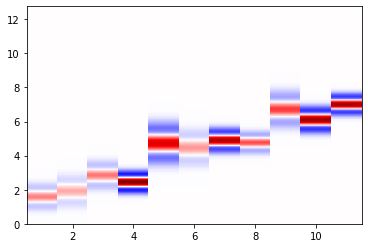

In [10]:
plt.figure()
vmax = np.max(source_list[0]['vec'])
t = np.arange(nt) * dt
n = np.arange(len(rupture['ix'])) + 0.5
n, t = np.meshgrid(n, t)
plt.pcolormesh(n, t, source_list[0]['vec'], vmax=vmax, vmin=-vmax, cmap='seismic')
# plt.colorbar()
plt.show()

In [11]:
def add_receiver(nrec, nsrc, nx, n_pml=0, types=[0]):
    rcv = {}
    rcv['ix'] = np.round(np.linspace(0+n_pml, nx-n_pml, nrec)).astype('int')
    rcv['iy'] = np.ones_like(rcv['ix']) * rcv_depth
    rcv['type'] = np.ones_like(rcv['ix'])
    
    rcvs = {}
    rcvs['ix'] = np.tile(rcv['ix'], len(types))   
    rcvs['iy'] = np.tile(rcv['iy'], len(types))  
    rcvs['type'] = np.hstack([rcv['type'] * i for i in types])
    
    return [rcvs] * nsrc
    
receiver_list = add_receiver(int(vp0/f0/dx)*4, nsrc, nx, n_pml, rcv_type)

In [12]:
def get_smooth_model(model, src):
#     vp = model['vp'].copy()
#     vp[:,rcv_depth+mask_extra_depth:src_depth-mask_extra_depth] = gaussian_filter(model['vp'][:, rcv_depth+mask_extra_depth:src_depth-mask_extra_depth], [10,10], mode='reflect')
#     vs = model['vs'].copy()
#     vs[:,rcv_depth+mask_extra_depth:src_depth-mask_extra_depth] = gaussian_filter(model['vs'][:, rcv_depth+mask_extra_depth:src_depth-mask_extra_depth], [10,10], mode='reflect')
#     rho = model['rho'].copy()
#     rho[:,rcv_depth+mask_extra_depth:src_depth-mask_extra_depth] = gaussian_filter(model['rho'][:, rcv_depth+mask_extra_depth:src_depth-mask_extra_depth], [10,10], mode='reflect')
    vp = model['vp'].copy()
    vp = gaussian_filter(model['vp'], [10,10], mode='reflect')
    vs = model['vs'].copy()
    vs = gaussian_filter(model['vs'], [10,10], mode='reflect')
    rho = model['rho'].copy()
    rho = gaussian_filter(model['rho'], [10,10], mode='reflect')
    
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = model['x']
    new_model['y'] = model['y']
    new_model['dx'] = model['dx']
    new_model['dy'] = model['dy']
    return new_model

smooth_model = get_smooth_model(model, source_list[0])

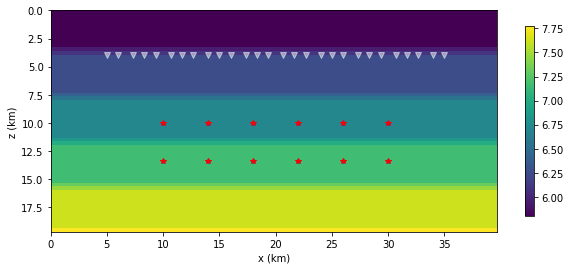

In [13]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, model['vp'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
plt.plot(x[rupture['ix']]-x0, y[rupture['iy']], 'b.')
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-vp.png"))
plt.show()

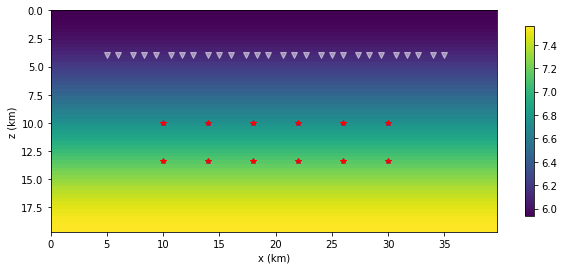

In [14]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, smooth_model['vp'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
plt.plot(x[rupture['ix']]-x0, y[rupture['iy']], 'b.')
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-smooth-vp.png"))
plt.show()

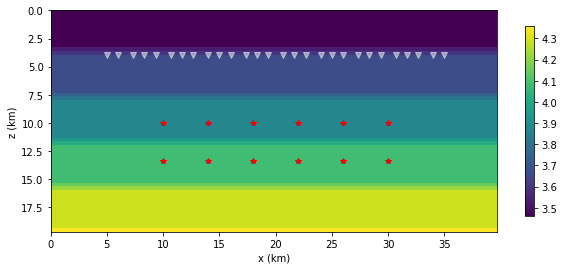

In [15]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, model['vs'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
plt.plot(x[rupture['ix']]-x0, y[rupture['iy']], 'b.')
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-vs.png"))
plt.show()

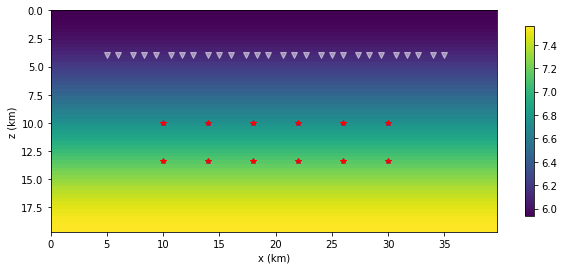

In [16]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, smooth_model['vp'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
plt.plot(x[rupture['ix']]-x0, y[rupture['iy']], 'b.')
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-smooth-vp.png"))
plt.show()

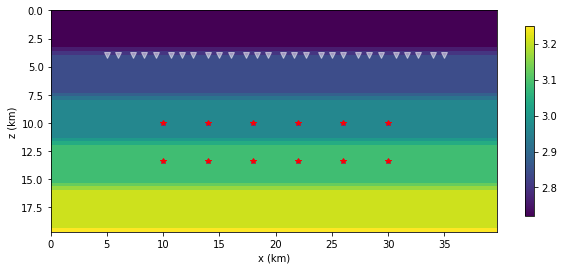

In [17]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, model['rho'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
plt.plot(x[rupture['ix']]-x0, y[rupture['iy']], 'b.')
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-rho.png"))
plt.show()

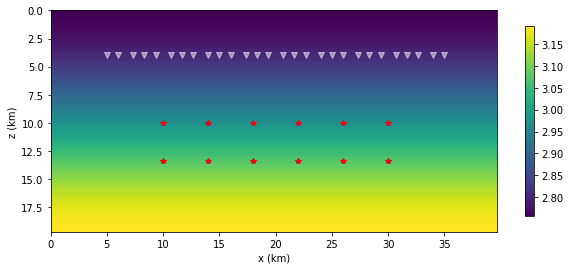

In [18]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]
plt.pcolormesh(x_mesh-x0, y_mesh, smooth_model['rho'].T)
plt.plot(x[receiver_list[0]['ix']]-x0, y[receiver_list[0]['iy']], 'wv', alpha=0.5)
plt.plot(x[rupture['ix']]-x0, y[rupture['iy']], 'b.')
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]-x0, y[source_list[i]['iy']], 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "layer-model-smooth-rho.png"))
plt.show()

In [19]:
scipy.io.savemat(os.path.join(out_dir, "layer-model-rupture-smooth.mat"), 
         {"vp" : smooth_model['vp'], 
         "vs" : smooth_model['vs'], 
         "rho" : smooth_model['rho'],
#          "vs" : anomaly_model['vs']*1000, 
#          "rho" : anomaly_model['rho']*1000,
         "source" : source_list,
         "receiver" : receiver_list,
         "rupture": rupture,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})

In [20]:
scipy.io.savemat(os.path.join(out_dir, "layer-model-rupture.mat"), 
         {"vp" : model['vp'], 
         "vs" : model['vs'], 
         "rho" : model['rho'],
         "source" : source_list,
         "receiver" : receiver_list,
         "rupture": rupture,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})